## Predicting Good Amazon Reviews

For this demo, we will be using the [Amazon Fine Food Reviews Data](https://www.kaggle.com/snap/amazon-fine-food-reviews).  The Amazon Fine Food Reviews dataset consists of 568,454 food reviews Amazon users left up to October 2012.

This script is based off of the [Craigslist Word2Vec Demo](https://github.com/h2oai/h2o-3/blob/master/h2o-py/demos/word2vec_craigslistjobtitles.ipynb).

## Import Data

We will begin by importing our review data into our H2O cluster.  In this case, I will be starting up an H2O cluster on my local computer.

In [2]:
import h2o

In [3]:
h2o.init(max_mem_size="4G")

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,20 hours 44 mins
H2O cluster timezone:,America/Denver
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.8
H2O cluster version age:,24 days
H2O cluster name:,H2O_from_python_pivotal_g3qr87
H2O cluster total nodes:,1
H2O cluster free memory:,2.182 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [4]:
# Use local data file or download from GitHub
import os
docker_data_path = "/home/h2o/data/nlp/AmazonReviews.csv"
if os.path.isfile(docker_data_path):
  data_path = docker_data_path
else:
  data_path = "https://s3.amazonaws.com/tomk/h2o-world/megan/AmazonReviews.csv"


# Load data into H2O
reviews = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
#' Add Target Column: "PositiveReview"
reviews["PositiveReview"] = (reviews["Score"] >= 4).ifelse("1", "0")

In [6]:
reviews.head()

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)",1
B002Q8JOSI,A17UQD2RSSQH5X,My dogs tell me these treats are YUMMY,5,1,212536,in the dark,1,1.31613e+09,"My two Corgis were thoroughly spoiled by my late husband (I spent a year and a half dieting them down a combined total of 25 pounds!)They are accustomed to the finest of fare, and they absolutely love the Wellness brand of treats.",1
B00176G870,A2F2MZW8EOGH5J,Yummy to the tummy,5,0,115971,"daemoncycler ""When you arrive at a fork in th...",0,1.33479e+09,We used to have drive down to the specialty pet food store for this product. So glad we discovered Amazon. As far as I can tell it is no more expensive & in some cases less - Prime membership is awesome. Loving Pets treats are some of the best according to my dog. They do not develop that nasty smell like some dog treats do.,1
B001CHFUGY,A2M8VROSDPU4JT,Very good coffee,5,1,434484,"Officefan ""Officefankt""",1,1.27725e+09,"I really liked this coffee, it was just as good as everyone claimed it was. Strong, bold and flavorful! I would recommend!",1
B0041CIR62,A16I6WJUEBJ1C3,okay but not as healthy as it appears,2,1,138997,"doctorsirena ""doctorsirena""",1,1.34369e+09,"I am always looking for healthier, whole grain versions of foods I enjoy. Unfortunately, these Peacock brand noodles are yet another food masquerading as healthy. The product title in big letters on the front says ""Brown Rice Vermicelli"", making the consumer think ""this is made with brown rice, so it should be a healthy choice"". But the first indication that it is not is when looking at the fiber content on the nutrition facts - only 0.6g per 2oz serving. Then onto the ingredients list to see why so low... contains brown rice, sago starch and water. The sago starch comes from palms and must not have much (if any) fiber.The Annie Chun's Maifun Brown Rice Noodles (sold on Amazon and in my local healthy grocer) has become one of my staples and is my frame of reference when comparing to the Peacock brand. The Annie Chun's product is made with 100% whole grain, with ingredients brown rice flour and water. Per 2oz serving, it has 4g fiber and pretty much the same calories and other nutrients as the Peacock brand.If you do try this Peacock brand noodles and have not used rice noodles before, you will need to seek guidance elsewhere on preparation. As others have pointed out, the Peacock package gives almost no directions on how to prepare the product, aside from a brief mention in the recipes (in the header text it does say that they are ""easy-to-cook"" but does not say how). It also contains a very strange recipe for rice noodles: Aglio Olio style - this is an Italian recipe for noodles with olive oil/garlic/sprinkled with grated cheese that I think would not be very tasty. The second recipe appears to be for a soup with veggie strips. Neither recipe gives amounts or much di

In [7]:
reviews["PositiveReview"].table()

PositiveReview,Count
0,21791
1,78209


## Train Baseline Model

We will start by training a baseline model that does not use the review and instead uses other attributes in our dataset.

In [8]:
# Find the 80th quantile of time in the dataset
time_split = reviews["Time"].quantile(prob = [0.8])[1]
reviews["Train"] = (reviews["Time"] < time_split).ifelse("Yes", "No")

In [9]:
train = reviews[reviews["Train"] == "Yes"]
test = reviews[reviews["Train"] == "No"]

In [10]:
from h2o.estimators import H2OGradientBoostingEstimator

predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time']
response = 'PositiveReview'

gbm_baseline = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                            stopping_rounds = 5, score_tree_interval = 10,
                                            model_id = "gbm_baseline.hex"
                                           )
gbm_baseline.train(x = predictors, y = response, 
                   training_frame = train, validation_frame = test
                  )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [11]:
print("AUC on Validation Data: " + str(round(gbm_baseline.auc(valid = True), 3)))

AUC on Validation Data: 0.616


We can see that there is a big room for improvement.  Our error is 22%.  To improve our model, we will train word embeddings for the review.

In [12]:
gbm_baseline.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45931625811239496: 


,0,1,Error,Rate
0,384.0,4276.0,0.9176,(4276.0/4660.0)
1,128.0,15220.0,0.0083,(128.0/15348.0)
Total,512.0,19496.0,0.2201,(4404.0/20008.0)


The variable importance plot below shows us that the most important variable is `HelpfulnessNumerator`.  Looking at the partial dependency plot for that variable, we see that the more people who find the review helpful, the more likely it is a good review.

In [13]:
gbm_baseline.varimp_plot()

<Figure size 1400x1000 with 1 Axes>

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


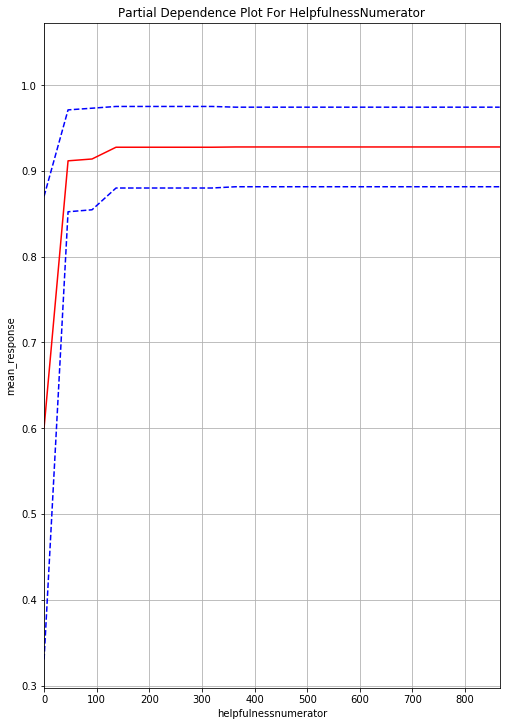

In [14]:
%matplotlib inline  
pdp_helpfulness = gbm_baseline.partial_plot(train, cols = ["HelpfulnessNumerator"])

## Tokenize Words in Review

Our first step will be to tokenize the words in the review column. We will do this by creating a function called `tokenize`.  This will split the reviews into words and remove any stop words, small words, or words with numbers in them.

In [15]:
# Set Stop Words
# The STOP WORDS we are importing are from the nltk package
import pandas as pd
import os

# Use local data file or download from GitHub
docker_data_path = "/home/h2o/data/nlp/stopwords.csv"
if os.path.isfile(docker_data_path):
  data_path = docker_data_path
else:
  data_path = "https://raw.githubusercontent.com/h2oai/h2o-tutorials/master/h2o-world-2017/nlp/stopwords.csv"

STOP_WORDS = pd.read_csv(data_path, header=0)
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])

In [16]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [17]:
# Break reviews into sequence of words
words = tokenize(reviews["Text"])

In [18]:
words.head()

C1
made
china
buy
pet
food
china
dogswell
using
propylene
glycol


## Train Word2Vec Model

Now that we've tokenized our words, we can train a word2vec model.  We can use the `find_synonms` function to sanity check our word2vec model after training.

In [19]:
# Train Word2Vec Model
from h2o.estimators.word2vec import H2OWord2vecEstimator

# This takes time to run - left commented out
w2v_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v.hex")
w2v_model.train(training_frame=words)

# Pre-trained model available on s3: https://s3.amazonaws.com/tomk/h2o-world/megan/w2v.hex
# w2v_model = h2o.load_model("/home/h2o/data/megan/w2v.hex")

word2vec Model Build progress: |██████████████████████████████████████████| 100%


In [20]:
# Sanity check - find synonyms for the word 'coffee'
w2v_model.find_synonyms("coffee", count = 5)

OrderedDict([('coffe', 0.8201382160186768),
             ('coffees', 0.8004502654075623),
             ('starbucks', 0.7675356864929199),
             ('espresso', 0.753750741481781),
             ('expresso', 0.7510795593261719)])

In [21]:
# Sanity check - find synonyms for the word 'stale'
w2v_model.find_synonyms("stale", count = 5)

OrderedDict([('rancid', 0.7176691293716431),
             ('moldy', 0.7084665298461914),
             ('inedible', 0.6672313213348389),
             ('expired', 0.6364622712135315),
             ('experation', 0.6157447695732117)])

Now that we have a word embedding for each word in our vocabulary, we will aggregate the words for each review using the `transform` function.  This will give us one aggregated word embedding for each review.

In [22]:
# Calculate a vector for each review
review_vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")

In [23]:
review_vecs

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
-0.0674852,0.0672925,-0.052915,0.0264624,0.00736256,0.046344,-0.0439823,0.031834,-0.175432,-0.0259239,0.0982949,-0.00614063,-0.044489,0.0443368,-0.0596667,0.127491,0.0875602,0.00249489,0.0263101,-0.198913,0.0408752,0.00899248,-0.222669,-0.197398,-0.0369012,-0.00997082,0.0229758,-0.0659072,0.0191909,0.129947,0.0387046,-0.0643705,-0.138217,0.0394413,-0.188669,0.00548671,0.101483,0.0197058,-0.18757,-0.024581,0.126647,0.0324345,0.0360013,0.179269,0.2276,-0.030728,0.0179543,-0.188669,0.0979562,0.137015,-0.0362485,0.0358284,0.177017,0.0725554,0.0339235,0.0774173,-0.0661313,0.0701474,0.0362037,-0.0473385,-0.155565,0.0562713,-0.0475695,-0.0149349,0.0919978,0.196947,-0.186393,-0.00678117,0.0232204,-0.0726256,-0.0459528,-0.0841345,0.0647559,0.0341675,0.0309288,-0.173624,0.0373693,0.119506,0.189733,-0.196852,0.0109531,0.0652695,-0.0293312,0.0380019,0.14369,-0.21746,0.032262,0.121118,-0.164091,0.217809,0.0651895,-0.0945643,-0.0786628,-0.0552099,0.0404553,0.131769,-0.0630445,-0.0772774,-0.198623,0.129663
-0.264712,0.0493389,0.107007,0.192801,-0.079546,-0.0320967,-0.0631987,-0.0548628,-0.0700696,-0.157942,-0.179209,-0.0240536,0.179178,-0.0766817,-0.0742535,0.0970892,0.0764087,0.154288,0.0485225,-0.00851813,-0.0773873,-0.129292,-0.0811819,0.0181895,0.171033,0.0481997,0.0429829,-0.000835153,-0.00839563,-0.00132193,-0.167642,-0.0676812,-0.126292,0.0382499,-0.071685,0.00773365,-0.0892863,-0.0809107,-0.103879,-0.166322,0.194647,0.018946,0.024342,0.111175,0.249763,0.110338,0.0719656,-0.197079,-0.078185,0.121941,-0.0941412,-0.0451929,-0.00330337,0.0326648,0.0551368,-0.0193628,-0.0853214,0.0513581,-0.0854208,-0.0434587,-0.00546279,-0.0181617,-0.0826927,-0.0967946,-0.102149,0.116525,-0.0158708,0.032523,-0.0563347,0.00788575,-0.246455,-0.169503,0.00162446,-0.00728927,0.0186481,0.0107428,0.227679,0.0841762,0.0497086,-0.191028,-0.110066,-0.055066,-0.0420014,-0.0403959,-0.0720173,-0.188723,0.0497209,-0.0438844,0.0203252,-0.0256118,-0.0108028,0.10467,-0.146303,-0.103468,-0.0108349,0.118403,0.0684458,-0.0395725,-0.0368514,0.0482058
-0.0874934,0.0256804,0.0936716,-0.00903683,0.051728,0.0472311,-0.0637765,-0.102511,-0.233607,-0.112201,-0.061004,0.0577248,-0.009179,0.0038658,0.0261578,0.179357,0.191748,0.0734615,0.0885183,-0.0292457,-0.0122607,0.00288349,-0.116494,-0.0420657,-0.0181406,-0.123748,0.0376292,0.0249346,-0.0475325,-0.0143374,-0.147876,0.0225801,-0.17764,0.0683859,0.0337552,0.0537426,-0.00290969,-0.00685071,-0.155184,0.081226,0.0875894,0.0334,0.0565576,0.219683,0.234613,-0.105096,-0.0550238,-0.077783,0.105325,0.133203,-0.0422714,-0.0223818,0.100654,-0.0495988,0.0481335,0.127773,-0.121328,0.155902,-0.0267461,-0.138388,-0.122905,0.133983,-0.0545373,0.028546,0.037727,0.203407,-0.102982,-0.0908399,-0.0346292,0.112667,-0.167162,-0.0857959,0.016497,0.0509868,0.0272359,0.083335,0.0114735,0.12156,0.0683165,-0.131229,0.0230671,0.149958,-0.0774502,0.0158572,0.0248237,-0.264859,-0.0155595,0.0132685,0.00738743,0.126595,-0.117289,0.0440969,-0.083066,-0.0440274,-0.0134758,0.0638001,-0.0296222,-0.0245805,-0.089971,0.0177277
-0.0714136,-0.0344456,0.0830657,0.106802,0.000184811,0.125682,-0.104275,-0.0294891,-0.1705,-0.0866579,0.0143481,0.0358722,0.0503196,-0.0156488,0.140975,0.175084,0.150508,0.12664,0.173187,0.052861,0.00256567,-0.0290768,-0.115981,-0.0730287,-0.00888958,0.116883,-0.000449506,-0.0337912,0.0177811,-0.0319613,-0.114809,-0.0722983,-0.0960354,0.0498819,0.0443919,0.02363,-0.0260572,-0.0576525,-0.139109,0.0465238,0.0650656,0.0921637,-0.0517693,0.12747,0.249987,-0.023553,0.108944,-0.12944,0.0355288,0.145679,-0.0136849,-0.054517,0.10011,-0.00318635,0.0189478,0.218314,-0

In [25]:
# Add aggregated word embeddings 
ext_reviews = reviews.cbind(review_vecs)
ext_reviews

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0,No,-0.0674852,0.0672925,-0.052915,0.0264624,0.00736256,0.046344,-0.0439823,0.031834,-0.175432,-0.0259239,0.0982949,-0.00614063,-0.044489,0.0443368,-0.0596667,0.127491,0.0875602,0.00249489,0.0263101,-0.198913,0.0408752,0.00899248,-0.222669,-0.197398,-0.0369012,-0.00997082,0.0229758,-0.0659072,0.0191909,0.129947,0.0387046,-0.0643705,-0.138217,0.0394413,-0.188669,0.00548671,0.101483,0.0197058,-0.18757,-0.024581,0.126647,0.0324345,0.0360013,0.179269,0.2276,-0.030728,0.0179543,-0.188669,0.0979562,0.137015,-0.0362485,0.0358284,0.177017,0.0725554,0.0339235,0.0774173,-0.0661313,0.0701474,0.0362037,-0.0473385,-0.155565,0.0562713,-0.0475695,-0.0149349,0.0919978,0.196947,-0.186393,-0.00678117,0.0232204,-0.0726256,-0.0459528,-0.0841345,0.0647559,0.0341675,0.0309288,-0.173624,0.0373693,0.119506,0.189733,-0.196852,0.0109531,0.0652695,-0.0293312,0.0380019,0.14369,-0.21746,0.032262,0.121118,-0.164091,0.217809,0.0651895,-0.0945643,-0.0786628,-0.0552099,0.0404553,0.131769,-0.0630445,-0.0772774,-0.198623,0.129663
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0,Yes,-0.264712,0.0493389,0.107007,0.192801,-0.079546,-0.0320967,-0.0631987,-0.0548628,-0.0700696,-0.157942,-0.179209,-0.0240536,0.179178,-0.0766817,-0.0742535,0.0970892,0.0764087,0.154288,0.0485225,-0.00851813,-0.0773873,-0.129292,-0.0811819,0.0181895,0.171033,0.0481997,0.0429829,-0.000835153,-0.00839563,-0.00132193,-0.167642,-0.0676812,-0.126292,0.0382499,-0.071685,0.00773365,-0.0892863,-0.0809107,-0.103879,-0.166322,0.194647,0.018946,0.024342,0.111175,0.249763,0.110338,0.0719656,-0.197079,-0.078185,0.121941,-0.0941412,-0.0451929,-0.00330337,0.0326648,0.0551368,-0.0193628,-0.0853214,0.0513581,-0.0854208,-0.0434587,-0.00546279,-0.0181617,-0.0826927,-0.0967946,-0.102149,0.116525,-0.0158708,0.032523,-0.0563347,0.00788575,-0.246455,-0.169503,0.00162446,-0.00728927,0.0186481,0.0107428,0.227679,0.0841762,0.0497086,-0.191028,-0.110066,-0.055066,-0.0420014,-0.0403959,-0.0720173,-0.188723,0.0497209,-0.0438844,0.0203252,-0.0256118,-0.0108028,0.10467,-0.146303,-0.103468,-0.0108349,0.118403,0.0684458,-0.0395725,-0.0368514,0.0482058
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)",1,Yes,-0.0874934,0.0256804,0.0936716,-0.00903683,0.051728,0.0472311,-0.0637765,-0.102511,-0.233607,-0.112201,-0.061004,0.0577248,-0.009179,0.0038658,0.0261578,0.179357,0.191748,0.0734615,0.0885183,-0.0292457,-0.0122607,0.00288349,-0.116494,-0.0420657,-0.0181406,-0.123748,0.0376292,0.0249346,-0.0475325,-0.0143374,-0.147876,0.0225801,-0.17764,0.0683859,0.0337552,0.0537426,-0.00290969,-0.00685

## Train GBM Model to Predict Good Review

We will train a GBM model with the same parameters as our baseline gbm.  This time, however, we will add the aggregated word embeddings as predictors. 

In [29]:
ext_train = ext_reviews[ext_reviews["Train"] == "Yes"]
ext_test = ext_reviews[ext_reviews["Train"] == "No"]

In [30]:
predictors = predictors + review_vecs.names
response = 'PositiveReview'

gbm_embeddings = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              model_id = "gbm_embeddings.hex"
                                             )
gbm_embeddings.train(x = predictors, y = response, 
                   training_frame = ext_train, validation_frame = ext_test
                  )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [31]:
print("Baseline AUC: " + str(round(gbm_baseline.auc(valid = True), 3)))
print("With Embeddings AUC: " + str(round(gbm_embeddings.auc(valid = True), 3)))
gbm_embeddings.model_performance(ext_test)

Baseline AUC: 0.616
With Embeddings AUC: 0.877

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.11608147690979345
RMSE: 0.34070731854451475
LogLoss: 0.36873822948117213
Mean Per-Class Error: 0.20436491424698078
AUC: 0.8770235262930065
Gini: 0.754047052586013
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5727812993721905: 


,0,1,Error,Rate
0,2101.0,2559.0,0.5491,(2559.0/4660.0)
1,601.0,14747.0,0.0392,(601.0/15348.0)
Total,2702.0,17306.0,0.1579,(3160.0/20008.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5727813,0.9032278,251.0
max f2,0.3497830,0.9494553,325.0
max f0point5,0.7923282,0.8992237,150.0
max accuracy,0.6470633,0.8437125,222.0
max precision,0.9846890,1.0,0.0
max recall,0.0565905,1.0,396.0
max specificity,0.9846890,1.0,0.0
max absolute_mcc,0.7133327,0.5460726,191.0
max min_per_class_accuracy,0.8054266,0.7945661,142.0
max mean_per_class_accuracy,0.7923282,0.7956351,150.0


Gains/Lift Table: Avg response rate: 76.71 %, avg score: 79.72 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100460,0.9792689,1.2906513,1.2906513,0.9900498,0.9816680,0.9900498,0.9816680,0.0129659,0.0129659,29.0651252,29.0651252
,2,0.0200420,0.9761062,1.2971045,1.2938698,0.995,0.9775857,0.9925187,0.9796319,0.0129659,0.0259317,29.7104509,29.3869834
,3,0.0300380,0.9735746,1.3036226,1.2971154,1.0,0.9747728,0.9950083,0.9780149,0.0130310,0.0389627,30.3622622,29.7115354
,4,0.0400340,0.9714567,1.3036226,1.2987401,1.0,0.9724587,0.9962547,0.9766276,0.0130310,0.0519937,30.3622622,29.8740140
,5,0.0500300,0.9697020,1.3036226,1.2997157,1.0,0.9705609,0.9970030,0.9754155,0.0130310,0.0650248,30.3622622,29.9715661
,6,0.1000600,0.9605700,1.2919017,1.2958087,0.9910090,0.9650073,0.9940060,0.9702114,0.0646338,0.1296586,29.1901739,29.5808700
,7,0.1500400,0.9521841,1.2723357,1.2879896,0.976,0.9565140,0.9880080,0.9656486,0.0635913,0.1932499,27.2335679,28.7989572
,8,0.2000200,0.9449454,1.2645139,1.2821236,0.97,0.9485798,0.9835082,0.9613836,0.0632004,0.2564504,26.4513943,28.2123598
,9,0.3000300,0.9271721,1.2606246,1.2749573,0.9670165,0.9364916,0.9780110,0.9530862,0.1260751,0.3825254,26.0624574,27.4957257
,10,0.3999900,0.9049543,1.2456114,1.2676235,0.9555,0.9164388,0.9723854,0.9439278,0.1245113,0.5070367,24.5611415,26.7623547


In [27]:
gbm_embeddings.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5972480358305947: 


,0,1,Error,Rate
0,2190.0,2470.0,0.53,(2470.0/4660.0)
1,802.0,14546.0,0.0523,(802.0/15348.0)
Total,2992.0,17016.0,0.1635,(3272.0/20008.0)


## Adding Summary

We saw that the review column is not the only column with text.  We also have a column called `Summary` which summarizes the review.  We will add the word embeddings of the summary to see if this improves our model.

In [28]:
# Break summaries into sequence of words
summary_words = tokenize(reviews["Summary"].ascharacter())

In [29]:
# Add aggregated summary word embeddings
summary_vecs = w2v_model.transform(summary_words, aggregate_method = "AVERAGE")
summary_vecs.names = ["summary_" + s for s in summary_vecs.names]

ext_reviews = ext_reviews.cbind(summary_vecs)

In [30]:
ext_train = ext_reviews[ext_reviews["Train"] == "Yes"]
ext_test = ext_reviews[ext_reviews["Train"] == "No"]

In [31]:
predictors = predictors + summary_vecs.names
response = 'PositiveReview'

gbm_plus_summary = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              model_id = "gbm_plus_summary.hex"
                                             )
gbm_plus_summary.train(x = predictors, y = response, 
                       training_frame = ext_train, validation_frame = ext_test
                      )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [32]:
print("Baseline AUC: " + str(round(gbm_baseline.auc(valid = True), 3)))
print("With Embeddings AUC: " + str(round(gbm_embeddings.auc(valid = True), 3)))
print("With Summary and Review Embeddings AUC: " + str(round(gbm_plus_summary.auc(valid = True), 3)))

Baseline AUC: 0.616
With Embeddings AUC: 0.872
With Summary and Review Embeddings AUC: 0.909


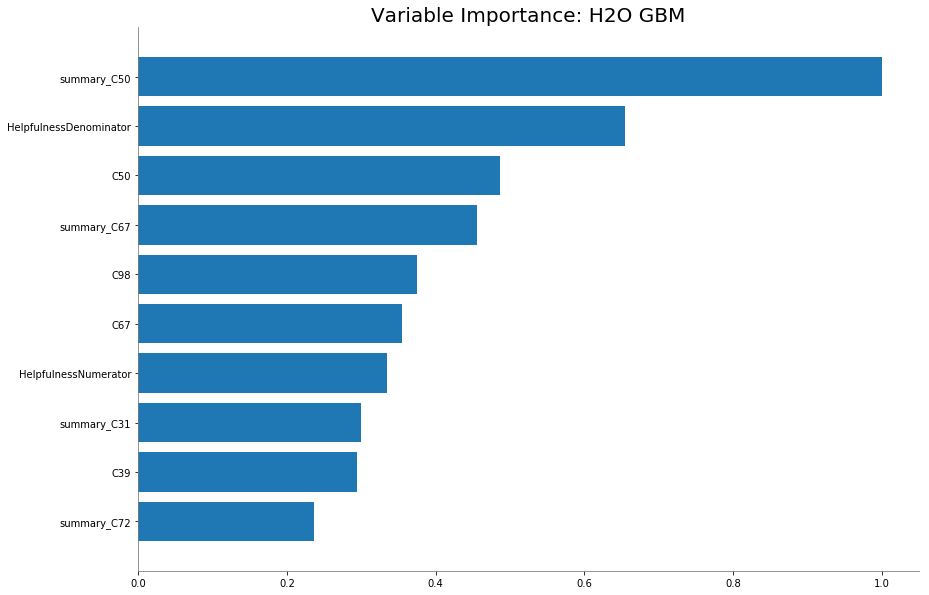

In [33]:
gbm_plus_summary.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


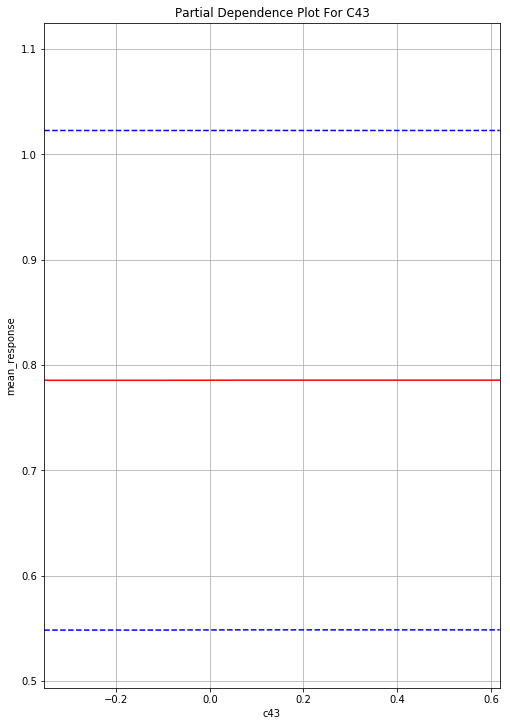

In [34]:
pdp_word_vecs = gbm_plus_summary.partial_plot(data = ext_train, cols = ["C43"])

We can see that a low `C43` is associated with a smaller probability of positive review.  Let's see what words have a low `C43` value.

In [35]:
# Get Word Embeddings per Word
unique_words = words.asfactor().unique().ascharacter()
unique_words.col_names = ["Word"]
word_embeddings = w2v_model.transform(unique_words, aggregate_method="None")
word_embeddings = unique_words.cbind(word_embeddings)
word_embeddings = word_embeddings[~(word_embeddings["C1"].isna())]

TypeError: bar() missing 1 required positional argument: 'x'

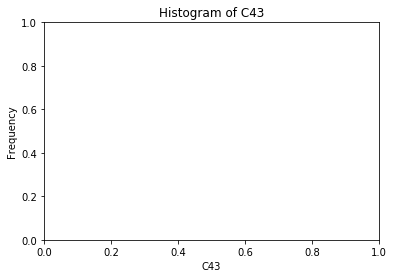

In [36]:
word_embeddings["C43"].hist()

In [ ]:
low_c43_words = word_embeddings[word_embeddings["C43"] < -1.1]
low_c43_words[["Word", "C43"]].head(15)

The words with low `C43` like `contacted`, `answered`, `emails`, `phone` and `refund` all seem to be related to contacting for a refund.  Words like: `salmonella` are obviously an indicator of a negative review for a food product.

## Predict on New Reviews

Now that we've built a model we are satisifed with, we will see how the model performs on new reviews.

* *"The taste is great! especially when you cook it with some vegetable and egg. I like it very much, though it's more expensive than the other noodles"*


* *"Quite tasteless and they make you order so many. I am stuck with 12 bags of this tasteless stuff. I am not ordering large amounts of anything from Amazon again. So often I don't like it and I am stuck with so much on hand."*

In [ ]:
def predict(reviews, w2v, gbm):
    
    words = tokenize(reviews["Text"].ascharacter())
    reviews_vec = w2v.transform(words, aggregate_method="AVERAGE")
    
    summary_words = tokenize(reviews["Summary"].ascharacter())
    summary_vec = w2v.transform(summary_words, aggregate_method="AVERAGE")
    
    model_data = reviews.cbind(reviews_vec).cbind(summary_vec)
    print(gbm.predict(model_data))

In [ ]:
good_review = h2o.H2OFrame([["B000EQT574", "AISQLBDGS2KXR", 1, 1, 1263340800, 
                             "Delicious",
                             "These chips are delicious. Salty sweet with a hint of spice. I have no idea how Tamari is supposed to taste, but these chips are awesome. I just finished an entire bag in one day!"]])

good_review.col_names = ["ProductId","UserId","HelpfulnessNumerator","HelpfulnessDenominator","Time","Summary","Text"]

In [ ]:
bad_review = h2o.H2OFrame([["B003BJZMSM", "A2JBZHQVQF7MV0", 1, 2, 1274832000, 
                            "Pretty tasteless",
                            "Quite tasteless and they make you order so many. I am stuck with 12 bags of this tasteless stuff. I am not ordering large amounts of anything from Amazon again. So often I don't like it and I am stuck with so much on hand."]])

bad_review.col_names = ["ProductId","UserId","HelpfulnessNumerator","HelpfulnessDenominator","Time","Summary","Text"]

In [ ]:
# Predict!
print("Good Review: ")
print(predict(good_review, w2v_model, gbm_embeddings))

print("Bad Review: ")
print(predict(bad_review, w2v_model, gbm_embeddings))

In [ ]:
h2o.cluster().shutdown()